In [59]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from transformers import BertTokenizer

In [60]:
df=pd.read_excel('dataset_filledsupplier_currency_orderday.xlsx')

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24621 entries, 0 to 24620
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   청구서번호        24621 non-null  object 
 1   No.          24621 non-null  int64  
 2   Subject      24599 non-null  object 
 3   Machinery    24621 non-null  object 
 4   Assembly     24621 non-null  object 
 5   청구품목         24621 non-null  object 
 6   Unnamed: 6   0 non-null      float64
 7   Part No.1    24602 non-null  object 
 8   Part No.2    3592 non-null   object 
 9   청구량          24517 non-null  float64
 10  견적           24171 non-null  object 
 11  견적수량         24517 non-null  float64
 12  견적화폐         24621 non-null  object 
 13  견적단가         24621 non-null  float64
 14  발주번호         24621 non-null  object 
 15  발주처          24621 non-null  object 
 16  발주           24621 non-null  object 
 17  발주수량         24621 non-null  int64  
 18  발주금액         24621 non-null  float64
 19  D/T 

In [62]:
print(len(df['발주처'].unique()))

81


## 클리닝

In [63]:
missing_conditions = df[
    df['발주'].notnull() &  # 발주 일자는 비어있지 않음
    df['미입고 기간'].isnull() &  # 미입고 기간은 비어있음
    df['창고입고'].isnull() & # 창고 입고도 비어있음
    df['선박입고'].isnull()  # 선박 입고도 비어있음

]

print(f"발주 일자는 있지만 미입고 기간, 창고 입고, 선박 입고도 없는 경우: {len(missing_conditions)}개")
df = df.drop(missing_conditions.index)

print(f"삭제된 행의 개수: {len(missing_conditions)}개")
print(f"남은 데이터프레임의 크기: {df.shape}")

발주 일자는 있지만 미입고 기간, 창고 입고, 선박 입고도 없는 경우: 1699개
삭제된 행의 개수: 1699개
남은 데이터프레임의 크기: (22922, 32)


In [64]:
#미입고기간으로 처리.
missing_both = df[df['창고입고'].isnull() & df['미입고 기간'].notnull()]

print(f"창고 입고일은 없고 미입고 기간은 명시되어 있어 미입고 기간으로 분류해야 할 경우 : {len(missing_both)}개")

창고 입고일은 없고 미입고 기간은 명시되어 있어 미입고 기간으로 분류해야 할 경우 : 1620개


In [65]:

df['발주'] = pd.to_datetime(df['발주'], errors='coerce')
df['창고입고'] = pd.to_datetime(df['창고입고'], errors='coerce')

# 리드타임 계산
df['리드타임'] = (df['창고입고'] - df['발주']).dt.days

# 리드타임이 0인 경우 1로 변경
df['리드타임'] = df['리드타임'].apply(lambda x: 1 if x == 0 else x)

In [66]:
df = df[df['미입고 기간'].isnull()]

df['발주'] = pd.to_datetime(df['발주'], errors='coerce')
df['창고입고'] = pd.to_datetime(df['창고입고'], errors='coerce')

# 리드타임 계산
df['리드타임'] = (df['창고입고'] - df['발주']).dt.days

# 리드타임이 0인 경우 1로 변경
df['리드타임'] = df['리드타임'].apply(lambda x: 1 if x == 0 else x)

# 리드타임이 1일 미만이거나 200일을 초과한 경우 제거
df = df[(df['리드타임'] > 0 ) & (df['리드타임'] < 200)]

# 창고입고가 결측값인 행 제거
df = df.dropna(subset=['창고입고'])

print(df.shape)

(19765, 33)


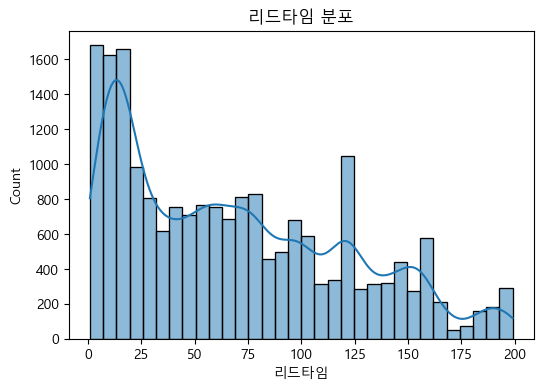

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# 리드타임 분포 확인
plt.rcParams['font.family']='Malgun Gothic'

plt.figure(figsize=(6, 4))
sns.histplot(df['리드타임'], kde=True)
plt.title('리드타임 분포')
plt.show()

In [68]:
df.head()

,청구서번호,No.,Subject,Machinery,Assembly,청구품목,Unnamed: 6,Part No.1,Part No.2,청구량,...,Control No.,입고창고,창고출고,창고출고수량,출고선박,출고운반선,선박입고,선박입고수량,완료 여부,리드타임
0,COK-BS-DSP-1901004,1,COK-F-DECK-190104-01,CARGO BOOM VANG BLOCK (STBD 하),BLOCK,"MCKISSICK CONSTRUCTION BLOCKS (WIRE SIZE : 5/8"")",NaN,C15S10BS,2103170,2.0,...,19-04-077,BW,2019-05-20,2,COK,ONENESS,2019-06-09,2,완료,112
1,COK-BS-DSP-1901004,2,COK-F-DECK-190104-01,SPANISH BOOM VANG BLOCK (PORT 상),BLOCK,"MCKISSICK CONSTRUCTION BLOCKS (WIRE SIZE : 5/8"")",NaN,C15D10BS,2103180,1.0,...,19-04-064,BW,2019-05-20,1,COK,ONENESS편 탁송,2019-06-09,1,완료,97
2,COK-BS-DSP-1901004,3,COK-F-DECK-190104-01,PURSE BLOCK,TOW BLOCK,WESTEC 20TON TOW BLOCK,NaN,WESTEC 20TON TOW BLOCK,NaN,1.0,...,19-04-077,BW,2019-05-20,1,COK,ONENESS,2019-06-09,1,완료,112
3,COK-BS-DSP-1905036,1,폰페이 재고정정,MAIN ENGINE,POWER PACK AS,GE POWER PACK FORK - E7(B),NaN,40028340,NaN,8.0,...,NaN,PN,2019-08-01,1,DEO,HANARO,2019-08-24,1,완료,1
4,COK-BS-DSP-1905036,2,폰페이 재고정정,MAIN ENGINE,POWER PACK AS,GE POWER PACK FORK - E7(B),NaN,40028340,NaN,8.0,...,NaN,PN,2019-08-29,7,ELS,SL ARCHI,2019-09-30,7,완료,1


In [69]:
print(df['리드타임'].describe())


count    19765.000000
mean        67.950873
std         52.245829
min          1.000000
25%         19.000000
50%         59.000000
75%        105.000000
max        199.000000
Name: 리드타임, dtype: float64


### 리드타임 예측 (회귀)
1. 텍스트 칼럼 결합 및 BERT 임베딩
2. ( 수치형 데이터(견적단가 및 발주량) Scaling )
3. 범주형 데이터(견적화폐) onehotEncoding
4. 모델의 입력, 2.3데이터 결합 => 리드타임 예측

## 전처리

> 각 텍스트 필드 개별적으로 rf idf 변환하고 결합

In [70]:
#!conda install conda-forge::category_encoders -y

In [91]:
machinery_avg_leadtime = df.groupby('Machinery')['리드타임'].mean().reset_index()
df = df.merge(machinery_avg_leadtime, on='Machinery', how='left', suffixes=('', '_avg'))

supplier_leadtime_avg = df.groupby('발주처')['리드타임'].mean().reset_index()
df = df.merge(supplier_leadtime_avg, on='발주처', how='left', suffixes=('', '_supplier_avg'))

In [105]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 환율 설정
exchange_rate = {
    'KRW': 1/1300, 
    'USD': 1,      
    'EUR': 1.1,     
    'JPY': 1/110    
}

# 수치형 칼럼 리스트
numeric_columns = ['log_converted_price', '리드타임_avg', '리드타임_supplier_avg', '발주수량'] 

# 수치형 데이터 처리 (로그 변환 및 NaN 처리)
df['converted_unit_price'] = df.apply(lambda x: x['견적단가'] * exchange_rate[x['견적화폐']], axis=1)
df['converted_price'] = df['converted_unit_price'] * df['발주수량']

# 로그 변환 전에 0 이하의 값 제거
df = df[df['converted_price'] > 0]

# 결측치 제거
df = df.dropna(subset=['converted_price', '발주수량'])
df['log_converted_price'] = np.log1p(df['converted_price'])

# NaN 값을 포함한 행을 삭제 (numeric_columns 기준으로)
df_cleaned = df.dropna(subset=numeric_columns)

# 선택된 수치형 칼럼만 가져옴
X_numeric = df_cleaned[numeric_columns]

# 데이터 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# PCA 수행
pca = PCA(n_components=len(numeric_columns))  # 모든 주성분을 얻기 위해 n_components를 변수 수로 설정
pca_result = pca.fit_transform(X_scaled)

# 주성분들이 설명하는 분산 비율
explained_variance = pca.explained_variance_ratio_

# 주성분에서의 기여도 확인 (PCA 결과에서 각 칼럼이 얼마나 기여했는지 확인)
components = pd.DataFrame(pca.components_, columns=numeric_columns)

print(f"Explained Variance Ratio: {explained_variance}")
print(f"PCA Components Contribution:\n{components}")

Explained Variance Ratio: [0.42815107 0.25730831 0.24157423 0.07296639]
PCA Components Contribution:
   log_converted_price  리드타임_avg  리드타임_supplier_avg      발주수량
0             0.077583  0.705433           0.704051 -0.025636
1             0.686122 -0.013918          -0.035209  0.726500
2             0.722910 -0.038154          -0.066435 -0.686682
3            -0.024870  0.707612          -0.706157  0.002820


In [106]:
## 수치형 PCA 결과와 리드타임 데이터 결합
y_numeric = df_cleaned['리드타임'].values  # 리드타임을 가져옴

# PCA 결과와 리드타임을 결합
pca_numeric_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
pca_numeric_df['리드타임'] = y_numeric

# 상관관계 계산
correlation_numeric = pca_numeric_df.corr()

# 리드타임과 주성분 간의 상관관계 출력
print("수치형 데이터 PCA 주성분과 리드타임의 상관관계:")
print(correlation_numeric['리드타임'])

수치형 데이터 PCA 주성분과 리드타임의 상관관계:
PC1     0.535133
PC2    -0.007834
PC3    -0.024814
PC4    -0.101619
리드타임    1.000000
Name: 리드타임, dtype: float64


> PC1 : 리드타임_avg와 리드타임_supplier_avg

In [107]:
from gensim.models import Word2Vec

# 데이터 전처리 후 토큰화 (문장을 단어 리스트로 변환)
machinery_sentences = [text.split() for text in df['cleaned_machinery']]
assembly_sentences = [text.split() for text in df['cleaned_assembly']]

# 각각의 Word2Vec 모델 학습
word2vec_machinery = Word2Vec(sentences=machinery_sentences, vector_size=100, window=5, min_count=1, workers=4)
word2vec_assembly = Word2Vec(sentences=assembly_sentences, vector_size=100, window=5, min_count=1, workers=4)

# 각 텍스트에 대한 벡터 평균값 계산 (문장 단위로 벡터를 평균화하여 문장 벡터 생성)
def sentence_vector(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# 각 컬럼별로 벡터화
machinery_vectors = np.array([sentence_vector(sentence, word2vec_machinery) for sentence in machinery_sentences])
assembly_vectors = np.array([sentence_vector(sentence, word2vec_assembly) for sentence in assembly_sentences])

# 4. 벡터 합치기 (machinery + assembly)
X_text = np.hstack([machinery_vectors, assembly_vectors])

# 5. 스케일링 (PCA 적용 전 스케일링)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_text)

# 6. PCA 적용 (주성분을 5개로 제한)
pca = PCA(n_components=5)
pca_result = pca.fit_transform(X_scaled)

# 7. 설명된 분산 비율 확인
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance Ratio: {explained_variance}")

# 8. 주성분 분석 기여도 확인
components = pca.components_

Explained Variance Ratio: [0.2240373  0.16731529 0.10755754 0.06643078 0.05989296]


In [108]:
# 텍스트 PCA 결과와 리드타임 데이터 결합
y_text = df_cleaned['리드타임'].values  # 리드타임을 가져옴

# 텍스트 PCA 결과와 리드타임을 결합
pca_text_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
pca_text_df['리드타임'] = y_text

# 상관관계 계산
correlation_text = pca_text_df.corr()

# 리드타임과 주성분 간의 상관관계 출력
print("텍스트 데이터 PCA 주성분과 리드타임의 상관관계:")
print(correlation_text['리드타임'])

텍스트 데이터 PCA 주성분과 리드타임의 상관관계:
PC1     0.119664
PC2     0.047677
PC3    -0.159888
PC4    -0.127443
PC5    -0.111427
리드타임    1.000000
Name: 리드타임, dtype: float64


In [72]:
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'[^\w\s\*/\-\+.,#&]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\b(사용금지|사)\b', '', text, flags=re.IGNORECASE)
    text = text.strip()
    return text
    
    
def clean_supplier_name(name):
    name = name.lower()
    name = re.sub(r'coporation|coropration|coproration|corporration', 'corporation', name)
    name = re.sub(r'\(사용금지\)', '', name)
    name = re.sub(r'u\.s\.a', '_usa', name)
    name = re.sub(r'\.', '', name)
    suffixes = r'(corporation|corp|company|co|incorporated|inc|limited|ltd|상사|공사|엔지니어링|주식회사|주|gmbh|pte ltd|llc)'
    name = re.sub(suffixes, '', name, flags=re.IGNORECASE)
    name = re.sub(r'[^\w\s-]', '', name)
    name = re.sub(r'\s+', ' ', name).strip()
    return name

In [99]:
text_columns = ['Machinery', 'Assembly', '청구품목', '발주처']

for col in text_columns:
    df[col] = df[col].astype(str)
df['cleaned_machinery'] = df['Machinery'].apply(preprocess_text)
df['cleaned_assembly'] = df['Assembly'].apply(preprocess_text)
df['cleaned_item'] = df['청구품목'].apply(preprocess_text)
df['cleaned_supplier'] = df['발주처'].apply(clean_supplier_name)

In [75]:
# BERT 입력을 위한 딕셔너리 형식으로 텍스트 결합
df['combined_text'] = (
    'machinery: ' + df['cleaned_machinery'].astype(str) + ', ' +
    'assembly: ' + df['cleaned_assembly'].astype(str) + ' ,' +
    '청구품목: ' + df['cleaned_item'].astype(str) + ', ' +
    '발주처: ' + df['cleaned_supplier'].astype(str)
)

In [77]:
from transformers import BertTokenizer, BertModel

# BERT 모델 불러오기 (이 부분은 huggingface의 BERT 모델을 사용)
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.to(device)

# 배치 단위로 BERT 임베딩 생성 함수
def generate_bert_embeddings(texts, batch_size):
    embeddings = []
    
    # 데이터를 배치 단위로 나누기
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        
        # BERT 토크나이징
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)
        
        # BERT 임베딩 계산
        with torch.no_grad():
            outputs = bert_model(**inputs)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # Mean pooling
            embeddings.append(batch_embeddings)
    
    # 모든 배치의 임베딩을 합치기
    embeddings = np.vstack(embeddings)
    return embeddings

# BERT 임베딩 생성
bert_embeddings = generate_bert_embeddings(texts, batch_size)

print(f"BERT Embeddings Shape: {bert_embeddings.shape}")

BERT Embeddings Shape: (19765, 768)


In [78]:
# 5. One-Hot Encoding: 견적화폐와 발주처
currency_ohe = OneHotEncoder(sparse_output=False) 
currency_encoded = currency_ohe.fit_transform(df[['견적화폐']])

print(f"currency_encoded : {currency_encoded.shape}")

currency_encoded : (19765, 4)


In [79]:
# BERT 임베딩과 currency_encoded 결합
X_final = np.hstack([bert_embeddings, currency_encoded])

In [80]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

# 리드타임 타겟
y = df['리드타임'].values

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)


### 데이터 분할

>  BERT 임베딩과 currency 인코딩을 각각 생성, 분리발주 

In [85]:
# NumPy 배열을 텐서로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # (batch_size, 1) 형식으로 변환
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# DataLoader를 위한 텐서 데이터셋 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# DataLoader를 통해 학습 루프에서 배치 단위로 데이터를 사용 가능
for batch_X, batch_y in train_loader:
    # 모델에 배치 단위로 데이터를 전달
    pass

In [86]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleMLPModel(nn.Module):
    def __init__(self, input_size, hidden_dim=512):
        super(SimpleMLPModel, self).__init__()
        # Fully connected layers for combined BERT + currency
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 256)
        self.fc3 = nn.Linear(256, 1)  # Output for regression
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [89]:
# 모델 초기화
input_size = X_train_tensor.shape[1]  # X_final의 열 크기를 input_size로 설정
model = SimpleMLPModel(input_size).to(device)

# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [90]:
# 학습 루프
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        # GPU로 데이터 이동
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # 순전파
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # 역전파 및 최적화
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # 에폭당 평균 손실 출력
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}')


Epoch 1/200, Loss: 2388.0497124867684
Epoch 2/200, Loss: 2081.798977781475
Epoch 3/200, Loss: 2015.0759808392809
Epoch 4/200, Loss: 1985.5054811915445
Epoch 5/200, Loss: 1948.4685135736263
Epoch 6/200, Loss: 1936.5196743956471
Epoch 7/200, Loss: 1911.3413602175197
Epoch 8/200, Loss: 1900.3977800297905
Epoch 9/200, Loss: 1875.4628289727036
Epoch 10/200, Loss: 1858.2436038056808
Epoch 11/200, Loss: 1849.9153060218803
Epoch 12/200, Loss: 1828.3162337284841
Epoch 13/200, Loss: 1829.2226943892583
Epoch 14/200, Loss: 1800.5944297181102
Epoch 15/200, Loss: 1789.478497511938
Epoch 16/200, Loss: 1791.7592809848766
Epoch 17/200, Loss: 1778.8377201863318
Epoch 18/200, Loss: 1770.4129304336225
Epoch 19/200, Loss: 1748.9768345662146
Epoch 20/200, Loss: 1745.3976523743602
Epoch 21/200, Loss: 1725.5268006975657
Epoch 22/200, Loss: 1726.1798146617184
Epoch 23/200, Loss: 1709.8302312374597
Epoch 24/200, Loss: 1692.8400686049968
Epoch 25/200, Loss: 1691.4141092483628
Epoch 26/200, Loss: 1675.09186414327

KeyboardInterrupt: 

In [ ]:
# 평가 과정 (테스트 데이터)
model.eval()  # 평가 모드로 설정
test_loss = 0.0

with torch.no_grad():  # 평가 시에는 역전파를 하지 않음
    for batch_bert, batch_currency, batch_y in test_loader:
        batch_bert = batch_bert.to(device)
        batch_currency = batch_currency.to(device)
        batch_y = batch_y.to(device)

        # Forward Pass
        outputs = model(batch_bert, batch_currency)
        loss = criterion(outputs, batch_y)

        test_loss += loss.item()

# 테스트 데이터에 대한 최종 평균 손실 출력
print(f"Test Loss: {test_loss/len(test_loader):.4f}")